*** Work in Progress ***

Pubmed Query Builder: https://pubmed.ncbi.nlm.nih.gov/advanced/

### Notes
* Dates stored in __repr__ format in JSON
* 000 = Code for unobtainable PMUID

### MeSH Terms
* Biomedical Engineering 
* Biomedical Technology
* Equipment Safety
* Equipment Design
* Prostheses and Implants

### Querys
(("Equipment and Supplies"[MeSH Terms] OR "Equipment Design"[MeSH Terms] OR "Equipment Safety"[MeSH Terms] OR "Biomedical Technology"[MeSH Terms] OR "Biomedical Engineering"[MeSH Terms]) AND 1850/01/01:1997/12/31[Date - Publication]) AND (English[Language])

(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) AND (("1850"[Date - Publication] : "1997"[Date - Publication]))

In [ ]:
'''
Future Work:
Use NLP for tokenization?'''

In [82]:
import pandas as pd
import json
import datetime
from collections import Counter  
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from pymed import PubMed

# Retrieve Data

In [2]:
# Uses Pymed to get results for the desired query
def search(query_string, pubmed_module, max_results=2000):
    results = pubmed_module.query(query_string, max_results=max_results)
    return results

In [78]:
# Gets relevant data from Pymed iterable and creates a dictionary
def pubmed_todict(pubmed_iterable):
    new_dict = {"Result Number": [], "Pubmed ID": [], "Title": [], "Journal": [], "Authors": [], "Date": []}
    
    # Assemble dictionary
    for i, article in enumerate(pubmed_iterable):
        new_dict["Result Number"].append(i)
        if "\n" in article.pubmed_id:  # Deals with parsing issue for article PMUID
            new_dict["Pubmed ID"].append("000")
        else:
            new_dict["Pubmed ID"].append(article.pubmed_id)   
        new_dict["Title"].append(article.title)
        try:  # Deals with book (rather than articles) in the database
            new_dict["Journal"].append(article.journal)
        except AttributeError:
            new_dict["Journal"].append("Book") 
        new_dict["Authors"].append(article.authors)
        if type(article.publication_date) == datetime.date:  # Standardizes data - pymed returns some years as int
            new_dict["Date"].append(article.publication_date) 
        else:
            new_dict["Date"].append(datetime.datetime.strptime(str(article.publication_date), "%Y"))
        
    # Cleans author data
    clean_author_list_by_paper = []
    for paper_author_list in new_dict["Authors"]:
        if paper_author_list == []:
            clean_author_list_by_paper.append([{"name": None, "affiliation": None}])
        else:
            author_list_by_paper = []
            for author in paper_author_list:
                if author["lastname"] != None or author["initials"] != None:
                    try:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                "affiliation": author["affiliation"]}
                    except KeyError:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                    "affiliation": None}
                    author_list_by_paper.append(author_dict)
            clean_author_list_by_paper.append(author_list_by_paper)
    
    new_dict["Authors"] = clean_author_list_by_paper
    
    return new_dict

In [7]:
# Avoids serialization error with datetime in JSON dump
# See https://stackoverflow.com/questions/54557568/typeerror-object-of-type-date-is-not-json-serializable
def datetime_converter(object):
    if isinstance(object, datetime.date):
        return object.__repr__()

In [8]:
def search_and_dump(query_string, max_results, file_name):
    pubmed = PubMed(tool="Medical Device Author Network Analysis", email="bowrey@umd.edu")
    results = search(query_string=query_string, pubmed_module=pubmed, max_results=max_results)
    new_dict = pubmed_todict(pubmed_iterable=results)
    with open(file_name, "w") as f:
        # Default argument takes function that is called when JSON ecounters object it can't convert
        json.dump(new_dict, f, indent=4, default=datetime_converter)
        print("Search Completed. File dumped to JSON")

In [79]:
# Searches for all items with "medical device(s)" in the title or abstract
search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
                                AND (("1850"[Date - Publication] : "1997"[Date - Publication]))''',
               max_results=2000, file_name="device_pubmed_data.json")

Search Completed. File dumped to JSON


# Publication Analysis

In [40]:
#TODO: Create Object for each search
def create_df(file_path):
    with open(file_path, "r") as f:
        full_dict = json.load(f)
    
    slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
    df = pd.DataFrame.from_dict(slim_dict)
    # df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    df["Date"] = df["Date"].apply(lambda x : eval(x).year)
    
    return df

In [41]:
device_df = create_df("device_pubmed_data.json")
device_df.head(20)

,Pubmed ID,Title,Journal,Date
0,000,Conditioning fluid influences on the surface p...,Journal of materials science. Materials in med...,2004
1,000,Monocyte-biomaterial interaction inducing phen...,Journal of materials science. Materials in med...,2004
2,12025581,American Nurses Association. Position statemen...,The Oklahoma nurse,2002
3,11364915,FDA reform signed into law. Food and Drug Admi...,AIDS treatment news,2001
4,11364819,FDA reform sails through Congress. Food and Dr...,GMHC treatment issues : the Gay Men's Health C...,2001
5,10179107,A study on the current situation in the biomed...,Journal of clinical engineering,1999
6,10174607,Development of a new Clinical Engineering Mana...,Journal of clinical engineering,1999
7,9696163,Technical standards for medical devices. Assis...,Technology and health care : official journal ...,1998
8,9526311,Reuse of disposables: is it worth the risk?,Canadian operating room nursing journal,1998
9,9513003,Why certification of medical software would be...,International journal of medical informatics,1998


### Cleaning
All articles with abnormal years (e.g. years outside of the range that was input to the API) are actually from 1997. Therefore, I correct all of these values accordingly.

In [42]:
def correct_years(df, cutoff_year):
    for index in df.loc[df["Date"] > cutoff_year].index:
        df.loc[index, "Date"] = cutoff_year
    
    return df

In [43]:
device_df = correct_years(df=device_df, cutoff_year=1997)
device_df.head(20)

,Pubmed ID,Title,Journal,Date
0,000,Conditioning fluid influences on the surface p...,Journal of materials science. Materials in med...,1997
1,000,Monocyte-biomaterial interaction inducing phen...,Journal of materials science. Materials in med...,1997
2,12025581,American Nurses Association. Position statemen...,The Oklahoma nurse,1997
3,11364915,FDA reform signed into law. Food and Drug Admi...,AIDS treatment news,1997
4,11364819,FDA reform sails through Congress. Food and Dr...,GMHC treatment issues : the Gay Men's Health C...,1997
5,10179107,A study on the current situation in the biomed...,Journal of clinical engineering,1997
6,10174607,Development of a new Clinical Engineering Mana...,Journal of clinical engineering,1997
7,9696163,Technical standards for medical devices. Assis...,Technology and health care : official journal ...,1997
8,9526311,Reuse of disposables: is it worth the risk?,Canadian operating room nursing journal,1997
9,9513003,Why certification of medical software would be...,International journal of medical informatics,1997


### Publications by Year

In [44]:
date_group = device_df.groupby(["Date"])

In [45]:
date_group["Pubmed ID"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

Date
1952      1
1955      1
1956      1
1957      1
1962      1
1964      1
1965      1
1967      1
1968      6
1969      3
1970      1
1971      9
1972      7
1973      9
1974      5
1975     10
1976     24
1977     29
1978     21
1979     36
1980     32
1981     21
1982     26
1983     29
1984     32
1985     37
1986     49
1987     38
1988     28
1989     35
1990     51
1991     90
1992     96
1993     97
1994     96
1995    158
1996    133
1997    154
Name: Pubmed ID, dtype: int64

In [49]:
device_pub_year_table = date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

<BarContainer object of 38 artists>

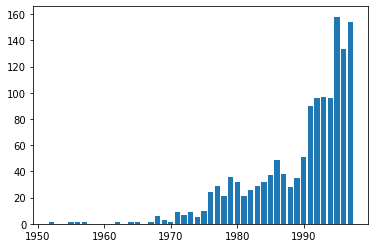

In [51]:
plt.bar(device_pub_year_table.index, [device_pub_year_table.get(x) for x in device_pub_year_table.index])

### Temporal Varience in Article Title Word Frequncy

For pie chart animation info: https://stackoverflow.com/questions/47358835/pie-chart-animation-in-python

In [79]:
def calculate_frequency(date_group=date_group, start_year=1952, end_year=1997):
    year_title_list = date_group["Title"].unique()
    
    # Exclude adpositions and auxiliary verbs
    exclude = ["a", "an", "the", "that", "of", "for", "and", "nor", "but", "or", "yet", "so", "to", 
           "by", "any", "on", "with", "as", "in", "at", "from", "medical", "device", "devices"]
    t_dict = {}
    
    for year in range(start_year, end_year + 1):
        t_dict[year] = {}
        try:
            for title in year_title_list[year]:
                title = title.strip(".? ")
                title = title.replace(";", "")
                title = title.replace(":", "")
                title = title.replace(r"(", "")
                title = title.replace(r")", "")
                title = title.replace("--", " ")
                title = title.split()
                for word in title:
                    word = word.lower()
                    word = word.replace(".", "")
                    if word in exclude:
                        pass
                    elif word in t_dict[year].keys():
                        t_dict[year][word] += 1
                    else:
                        t_dict[year][word] = 1
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    return t_dict

In [84]:
def most_frequent(data_dict, most_common_n):
    top_dict = {}
    for item in data_dict:
        if item == {}:
            pass
        else:
            for word in data_dict[item]:
                if word in top_dict.keys():
                    top_dict[word] += 1
                else:
                    top_dict[word] = 1
                    
    top_final = [(k,v) for k,v in Counter(top_dict).most_common(most_common_n)]
    
    return top_final

In [80]:
device_tvd = calculate_frequency(date_group=date_group, start_year=1952, end_year=1997)

In [97]:
frequency = most_frequent(data_dict=device_tvd, most_common_n=20)

<BarContainer object of 20 artists>

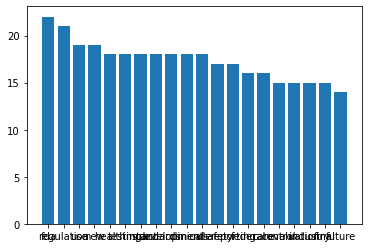

In [98]:
plt.bar(x=[x[0] for x in frequency], height=[x[1] for x in frequency])

# Network Anaylsis

In [48]:
'''
class Author:
    def __init__(self, ident, name, affiliation, weight):
        self.ident = ident
        self.name = name
        self.affiliation = affiliation
        self.weight = weight
'''

'\nclass Author:\n    def __init__(self, ident, name, affiliation, weight):\n        self.ident = ident\n        self.name = name\n        self.affiliation = affiliation\n        self.weight = weight\n'

In [49]:
def get_author_info(auth_list , write_file):
    identifier_list = {}
    id_count = 1
    
    for paper in auth_list:
        for author in paper:
            # Create data structure for author
            if author["name"] == None:
                pass
            elif author["name"].lower() in [item.lower() for item in identifier_list.keys()]:
                identifier_list[author["name"]]["weight"] += 1
            else:
                identifier_list[author["name"]]  = {"id": id_count, "affiliation":author["affiliation"], "weight": 1, "edges":[]}

            # Append other authors to edges list
            temp_list = [o_author["name"] for o_author in paper]
            for item in temp_list:
                if item != author["name"]:
                    identifier_list[author["name"]]["edges"].append(item) 

            id_count +=1
            
    with open(write_file, "w") as f:
        json.dump(identifier_list, f, indent=4)

In [50]:
with open("device_pubmed_data.json", "r") as f:
    auth_list = json.load(f)["Authors"]
    get_author_info(auth_list=auth_list , write_file="device_author_data.json")

In [51]:
with open("device_author_data.json") as f:
    test = json.load(f)
print(len(test))

1994
